# 16강. 난 스케치를 할 테니 너는 채색을 하거라
## 16-4. 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기
### 데이터 준비하기

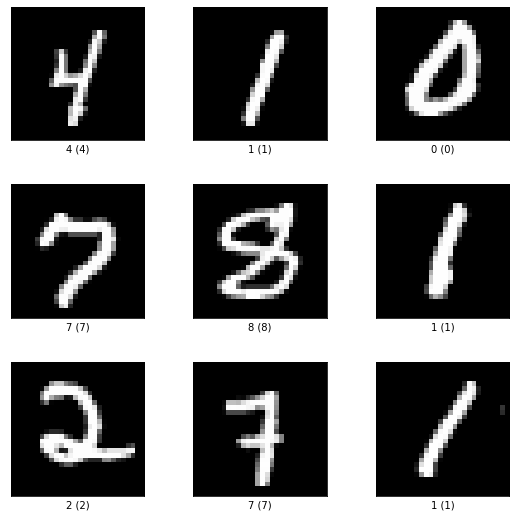

In [1]:
# tensorflow-datasets 라이브러리에서 MNIST 데이터셋 불러오기
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

In [2]:
import tensorflow as tf

BATCH_SIZE = 128

# 이미지 픽셀 값을 -1~1 사이의 범위로 변경 및 레이블 정보를 원-핫 인코딩(one-hot encoding)
def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

Label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


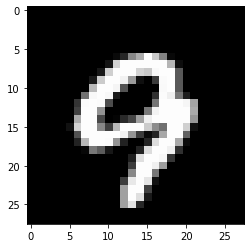

In [3]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인    
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

### GAN Generator 구성하기

In [4]:
# GAN의 Generator
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

- Tensorflow2의 Subclassing : tensorflow.keras.Model 을 상속받아 클래스를 만들며, 일반적으로 init() 메서드 안에서 레이어 구성을 정의하고, 구성된 레이어를 call() 메서드에서 사용해 forward propagation을 진행한다.  
- init() 메서드 안에서 사용할 모든 레이어를 정의(4개의 fully-connected 레이어 중 한 개를 제외하고 모두 ReLU 활성화를 사용) -> call() 메서드에서는 노이즈를 입력받아 init()에서 정의된 레이어들을 순서대로 통과 -> Generator는 숫자가 쓰인 이미지를 출력해야 하므로 마지막 출력은 layers.Reshape()을 이용해 (28,28,1) 크기로 변환

### cGAN Generator 구성하기

In [5]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)

- 노이즈 입력 및 레이블 입력은 각각 1개의 fully-connected 레이어와 ReLU 활성화를 통과 (dense_z, dense_y) -> 각 결과가 서로 연결되어 다시 한번 1개의 fully-connected 레이어와 ReLU 활성화를 통과 (tf.concat, conbined_dense) -> 1개의 fully-connected 레이어 및 Hyperbolic tangent 활성화를 거쳐 28x28 차원의 결과가 생성되고 (28,28,1) 크기의 이미지 형태로 변환되어 출력 (final_dense, reshape)

## 16-5. 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기
### GAN Discriminator 구성하기

In [6]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x

- init()에 blocks라는 리스트를 하나 만들고, for문을 이용하여 필요한 레이어 쌓기  
- Generator가 생성한 (28,28,1) 크기의 이미지를 Discriminator에 입력 -> fully-connected 레이어로 학습하기 위해 call()에서는 가장 먼저 layers.Flatten()이 적용 -> 이어서 레이어들이 쌓여있는 blocks에 대해 for문을 이용하여 레이어들을 순서대로 하나씩 꺼내 입력 데이터를 통과 -> 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값 출력

### cGAN Discriminator 구성하기

In [7]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

- Maxout 레이어 : units과 pieces의 설정이 필요 -> units 차원 수를 가진 fully-connected 레이어를 pieces개만큼 만들고 그중 최댓값을 출력한다.

In [8]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)

- Discriminator에 Generator가 생성한 (28,28,1) 크기의 이미지가 입력 -> Flatten -> 이미지 입력 및 레이블 입력 각각은 Maxout 레이어를 한 번씩 통과한 후 서로 결합되어 Maxout 레이어를 한 번 더 통과 -> fully-connected 레이어를 통과하여 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력

## 16-6. 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기

In [9]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)

### GAN으로 MNIST 학습하기

In [10]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100]) # 노이즈 100차원으로
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

In [11]:
# 학습하기
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0: # 100번의 반복마다 각 손실(loss)을 출력
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.2885355949401855, D:0.13158170878887177
[1/10 EPOCHS, 200 ITER] G:2.4524283409118652, D:0.12284635007381439
[1/10 EPOCHS, 300 ITER] G:2.5518436431884766, D:0.142513245344162
[1/10 EPOCHS, 400 ITER] G:3.202744483947754, D:0.2484074831008911
[2/10 EPOCHS, 100 ITER] G:3.2755064964294434, D:0.11057209968566895
[2/10 EPOCHS, 200 ITER] G:2.433135509490967, D:0.19341659545898438
[2/10 EPOCHS, 300 ITER] G:4.257072925567627, D:0.10802429914474487
[2/10 EPOCHS, 400 ITER] G:2.5489678382873535, D:0.2804492115974426
[3/10 EPOCHS, 100 ITER] G:3.7554931640625, D:0.05865474417805672
[3/10 EPOCHS, 200 ITER] G:3.153334140777588, D:0.14759987592697144
[3/10 EPOCHS, 300 ITER] G:4.252040386199951, D:0.10963205993175507
[3/10 EPOCHS, 400 ITER] G:3.417440176010132, D:0.09893754869699478
[4/10 EPOCHS, 100 ITER] G:2.863101005554199, D:0.12584777176380157
[4/10 EPOCHS, 200 ITER] G:4.417730331420898, D:0.1912815421819687
[4/10 EPOCHS, 300 ITER] G:4.489819526672363, D:0.100795365869998

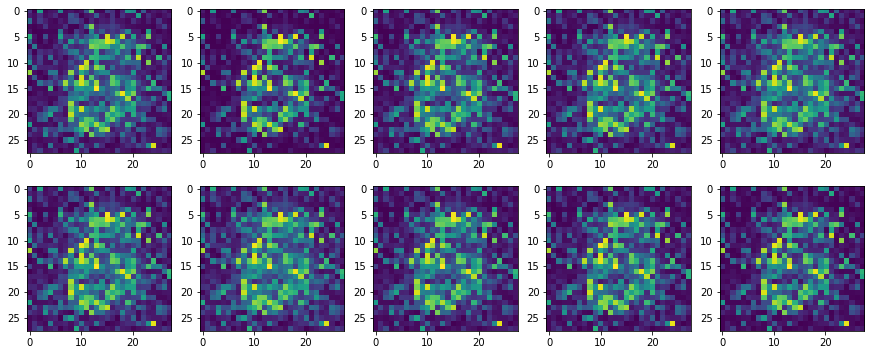

In [12]:
# 시각화(100차원 노이즈 입력 10개)
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

##### cf. 500 epoch 학습한 가중치로 시각화

![준비](https://user-images.githubusercontent.com/116326867/210944684-5372235c-4885-4461-9724-86b8696b87ae.png)

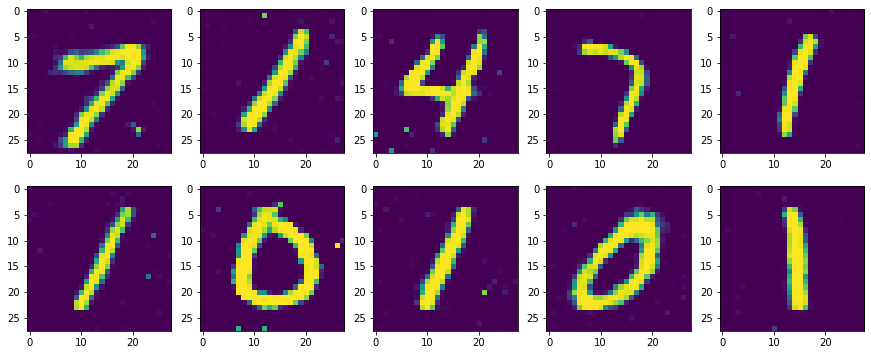

In [13]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

### cGAN으로 MNIST 학습하기

In [14]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:5.614733695983887, D:0.006113000679761171
[1/1 EPOCHS, 199 ITER] G:2.5203115940093994, D:0.1398073434829712
[1/1 EPOCHS, 299 ITER] G:7.01548433303833, D:0.02354993112385273
[1/1 EPOCHS, 399 ITER] G:5.730424880981445, D:0.012753482908010483


- GAN과 비교했을 때, Generator 및 Discriminator에 레이블 정보만 추가로 입력  
- 충분한 학습을 위해서는 epochs 늘리기(시간을 더 투자할 필요가 있다)

##### cf. 500 epoch 학습한 가중치로 시각화

![준비](https://user-images.githubusercontent.com/116326867/210946371-e82cac8b-8305-420f-993d-b07ab8bf8c60.png)

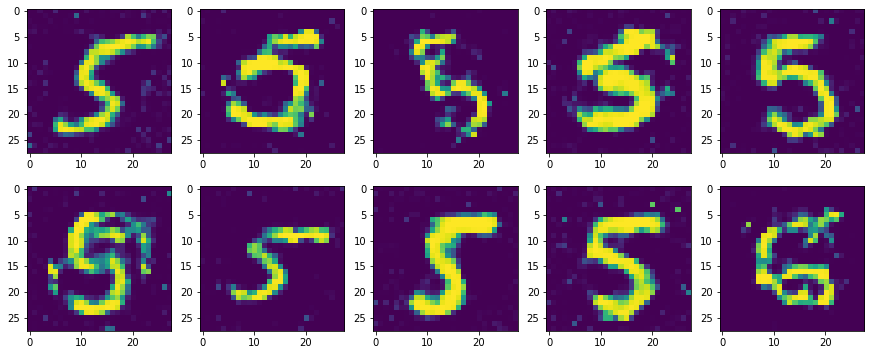

In [15]:
number = 5  # 생성할 숫자를 입력

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

## 16-8. 난 스케치를 할 테니 너는 채색을 하거라 (1) 데이터 준비하기
- [pokemon데이터셋](https://www.kaggle.com/datasets/norod78/sketch2pokemon) : 학습용 데이터 셋에 830개의 이미지, 각 (256x256) 크기의 이미지 쌍이 나란히 붙어 (256x512) 크기의 이미지로 구성

#### 데이터 준비

![데이터준비](https://user-images.githubusercontent.com/116326867/211160490-2f47521b-b77e-412d-a3a9-db3aefea03aa.png)

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


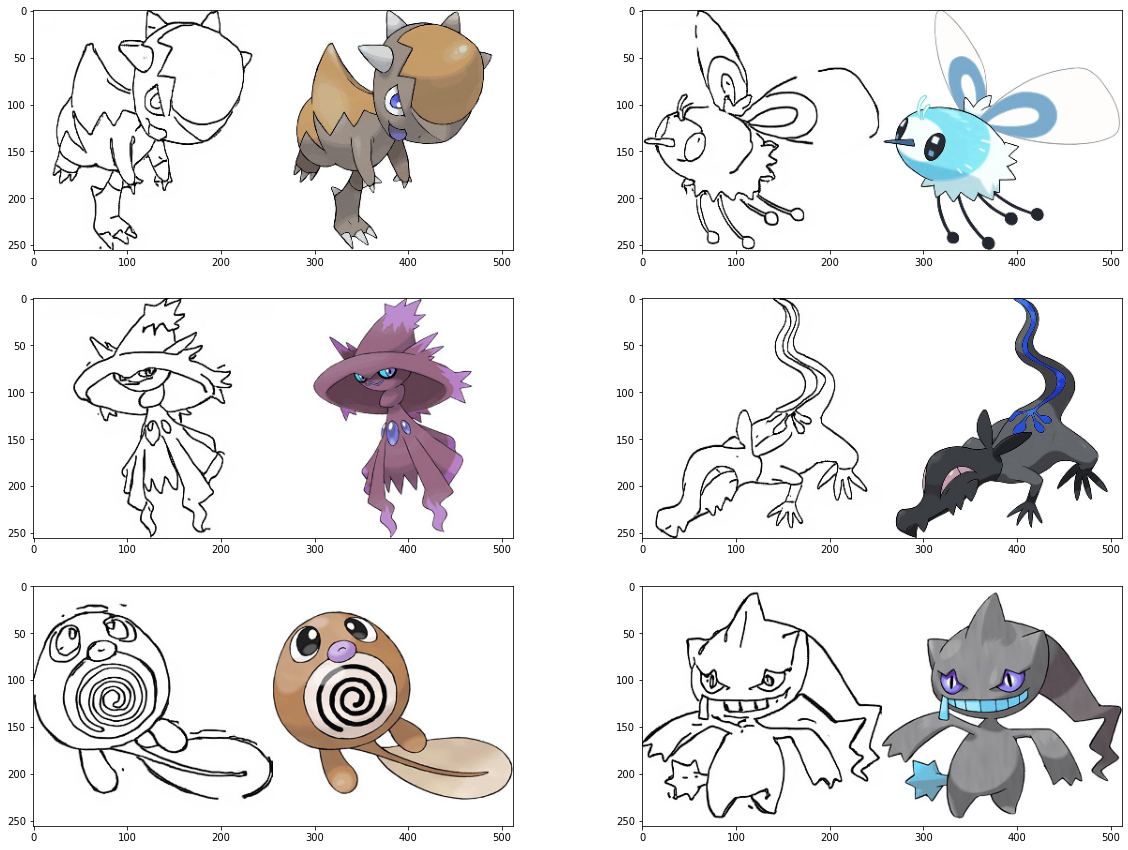

In [2]:
# 데이터셋 랜덤으로 6개 시각화
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

- 직접 그려서 만든 데이터셋이 아닌 스케치 생성 모델을 이용해서 만들었기 때문에 일부는 제대로 스케치되지 않은 이미지가 있다.

In [3]:
# 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


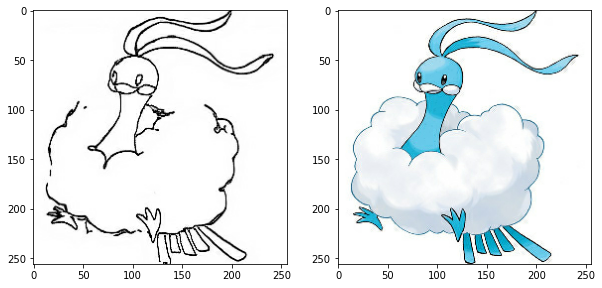

In [4]:
# 이미지 나누기
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [5]:
# 여러 augmentation 방법 적용(for 학습에 사용하는 데이터의 다양성 확보)
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    # 두 이미지를 채널 축으로 연결(ex. 두 이미지가 각각 3채널인 경우 6채널이 된다.)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    # 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용

    out = image.random_crop(padded, size=[256, 256, 6])
    # (256,256,6) 크기를 가진 이미지를 임의로 잘라내기
    
    out = image.random_flip_left_right(out) # 50% 확률로 가로로 뒤집기
    out = image.random_flip_up_down(out) # 50% 확률로 세로로 뒤집기
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    # 50% 확률로 회전시키기
    
    return out[...,:3], out[...,3:]

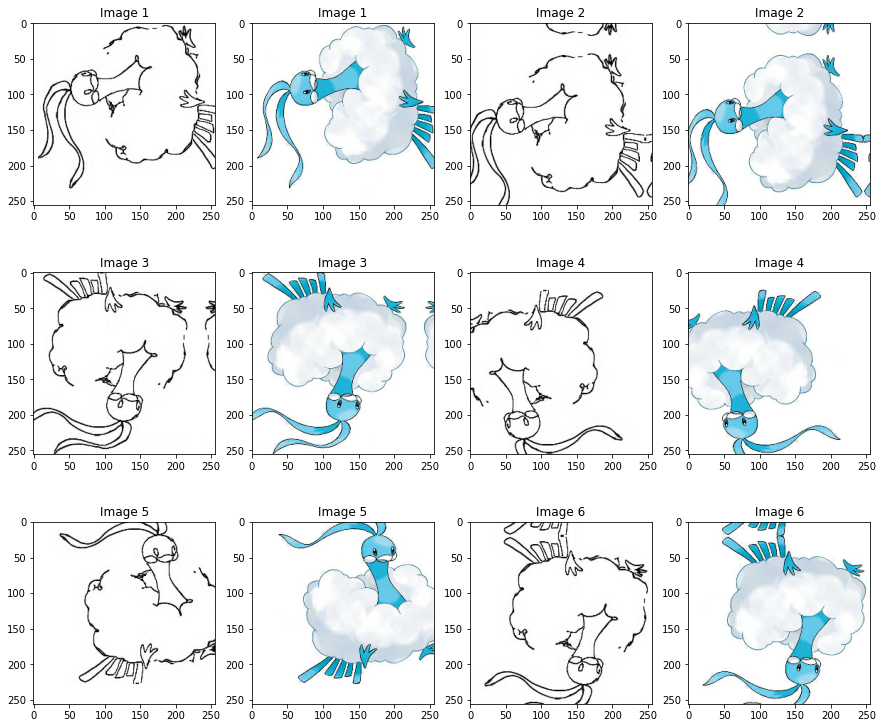

In [6]:
# 위의 결과 시각화
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

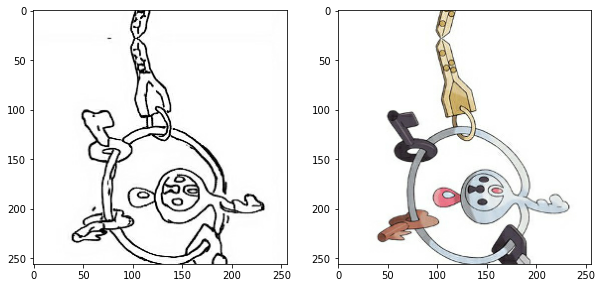

In [7]:
# 학습데이터에 적용하기
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

# 하나의 이미지만 시각화하여 확인
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 16-9. 난 스케치를 할 테니 너는 채색을 하거라 (2) Generator 구성하기

![이미지](https://user-images.githubusercontent.com/116326867/211182118-3ccbfe7e-7d15-424c-aa98-b992f27c19d9.png)

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False) # filter size = 4 및 stride = 2
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2) # slope coefficient = 0.2
        # Encoder : Convolution → BatchNorm → LeakyReLU 3개의 레이어로 구성

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [9]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512] # 각 블록을 거치면서 사용할 필터의 개수
        
        self.blocks = [] # 사용할 블록들을 정의
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False)) # Encoder 첫 번째 블록에서는 BatchNorm 사용하지 않음
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x): # 차례대로 블록들을 통과
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [10]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [11]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        # Decoder : Transpose Convolution → BatchNorm → Dropout → LeakyReLU 4개의 레이어로 구성
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f)) # 처음 세 개의 블록에서만 Dropout을 사용
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        # 마지막 convolution에는 3개의 필터를 사용해 출력
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [12]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [13]:
# tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성하기
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## 16-10. 난 스케치를 할 테니 너는 채색을 하거라 (3) Generator 재구성하기

In [14]:
# 일반 Encode, Decode Block
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [15]:
# U-Net Generator 정의
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    # forward propagation(skip connection 구현)
    def call(self, x):
        features = [] # for skip connection
        for block in self.encode_blocks: # encoder 내부 연산
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]): # decoder 내부 연산
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

- skip connection : features 리스트를 만들기 -> Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담기 -> Decoder 블록들 통과 시, features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용  
- features = features[:-1] : Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아니기 때문에 사용된다.  
- features[::-1] : Encoder와 Decoder는 대칭을 이루고 있기 때문에 사용된다.  
- 데이터 A = (32,128,128,200), 데이터 B = (32,128,128,400) # (batch, width, height, channel) 일 때, skip connection의 layers.Concatenate() 결과의 크기 = (128,128,600) : 별다른 설정이 없다면 가장 마지막 축(채널 축)을 기준으로 서로 연결하기 때문.

In [16]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

- U-Net Generator에서 사용한 skip-connection으로 인해 Decoder의 각 블록에서 입력받는 채널 수가 늘어났고, 이에 따라 블록 내 convolution 레이어에서 사용하는 필터 크기가 커지면서(concatenate로 두 배가 됨) 학습해야 할 파라미터가 늘어났다.  

## 16-11. 난 스케치를 할 테니 너는 채색을 하거라 (4) Discriminator 구성하기

In [17]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad # 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정
        self.use_bn = use_bn # BatchNorm의 사용 여부 설정
        self.act = act # 활성화 함수 사용 여부 설정
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn: 
            x = self.batchnorm(x)
            
        if self.act: 
            x = self.lrelu(x)
        return x 

Q. DiscBlock(n_filters=64, stride=1, custom_pad=True, use_bn=True, act=True)으로 생성된 블록에 (width, height, channel) = (128, 128, 32) 크기가 입력되었다면, 블록 내부에서 순서대로 어떠한 레이어를 통과하는가? 그리고 각 레이어를 통과했을 때 출력 크기는 어떻게 되는가?  
1. layers.ZeroPadding2D() : width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어난다. -> (130,130,32)  
2. layers.Conv2D(64,4,1,"valid") : OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1, 채널 수는 사용한 필터 개수와 동일 -> 패딩하지 않았기 때문에 PadSize=0 FilterSize=4, Stride=1일 때, OutSize = InSize - 3 & n_filters=64 -> (127,127,64)  
3. layers.BatchNormalization() : 출력의 크기에 영향 주지 않는다. -> (127,127,64)  
4. layers.LeakyReLU(0.2) : 출력의 크기에 영향 주지 않는다. -> (127,127,64)  

In [18]:
# 크기 확인
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


- 이런 식으로 (width, height) 크기를 1씩 감소시킬 수 있으므로, 마지막 2개 블록에서 출력의 크기가 1씩 감소할 때 이런 방식을 적용할 수 있다.

In [19]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # 위의 식을 for문으로 돌리는 경우 코드
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [20]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

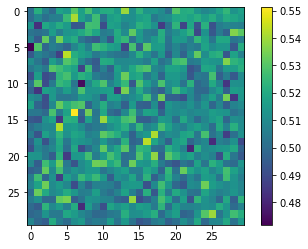

In [21]:
# (256,256,3) 크기의 입력 -> (30,30)출력 시각화
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

- (70,70) 패치에 대한 분류 결과 -> 각각의 픽셀 값은 sigmoid 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해 내는 데 사용된다.

## 16-12. 난 스케치를 할 테니 너는 채색을 하거라 (5) 학습 및 테스트하기

In [22]:
# GAN의 손실 함수에 L1을 추가로 이용하기
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

- Generator의 손실 함수(get_gene_loss) : fake_disc -> Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용) / fake_output(가짜 이미지), real_output(실제 이미지) -> MAE(Mean Absolute Error)를 계산하여 L1 손실을 계산.  
- Discriminator의 손실 함수(get_disc_loss) : fake_disc(가짜 이미지가 Discriminator에 입력되어 얻어진 값), real_disc(실제 이미지가 Discriminator에 입력되어 얻어진 값) -> real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교.

In [23]:
# optimizer
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [24]:
# 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정 정의
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## L1 손실 반영(λ=100으로 설정)
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [25]:
# 학습하기
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9241                     
L1_loss:0.4844                     
Discriminator_loss:1.1480

EPOCH[1] - STEP[20]                     
Generator_loss:0.9369                     
L1_loss:0.2983                     
Discriminator_loss:1.3162

EPOCH[1] - STEP[30]                     
Generator_loss:0.8305                     
L1_loss:0.2619                     
Discriminator_loss:1.1918

EPOCH[1] - STEP[40]                     
Generator_loss:1.1907                     
L1_loss:0.2712                     
Discriminator_loss:0.8988

EPOCH[1] - STEP[50]                     
Generator_loss:1.5586                     
L1_loss:0.2192                     
Discriminator_loss:0.9870

EPOCH[1] - STEP[60]                     
Generator_loss:1.6571                     
L1_loss:0.2924                     
Discriminator_loss:0.5972

EPOCH[1] - STEP[70]                     
Generator_loss:1.6571                     
L1_loss:0.2648                    

EPOCH[3] - STEP[170]                     
Generator_loss:1.2234                     
L1_loss:0.2418                     
Discriminator_loss:1.6301

EPOCH[3] - STEP[180]                     
Generator_loss:0.8145                     
L1_loss:0.2808                     
Discriminator_loss:0.7102

EPOCH[3] - STEP[190]                     
Generator_loss:2.9861                     
L1_loss:0.2326                     
Discriminator_loss:0.9960

EPOCH[3] - STEP[200]                     
Generator_loss:2.7275                     
L1_loss:0.2902                     
Discriminator_loss:0.4003

EPOCH[4] - STEP[10]                     
Generator_loss:1.6718                     
L1_loss:0.2916                     
Discriminator_loss:0.5468

EPOCH[4] - STEP[20]                     
Generator_loss:3.2741                     
L1_loss:0.2550                     
Discriminator_loss:0.2821

EPOCH[4] - STEP[30]                     
Generator_loss:3.9229                     
L1_loss:0.2660                

EPOCH[6] - STEP[130]                     
Generator_loss:0.3901                     
L1_loss:0.2421                     
Discriminator_loss:1.3972

EPOCH[6] - STEP[140]                     
Generator_loss:3.5659                     
L1_loss:0.2113                     
Discriminator_loss:0.6493

EPOCH[6] - STEP[150]                     
Generator_loss:2.9977                     
L1_loss:0.2335                     
Discriminator_loss:0.6332

EPOCH[6] - STEP[160]                     
Generator_loss:1.9780                     
L1_loss:0.2683                     
Discriminator_loss:1.4946

EPOCH[6] - STEP[170]                     
Generator_loss:0.3203                     
L1_loss:0.2235                     
Discriminator_loss:2.1953

EPOCH[6] - STEP[180]                     
Generator_loss:1.7635                     
L1_loss:0.2400                     
Discriminator_loss:0.3529

EPOCH[6] - STEP[190]                     
Generator_loss:0.3887                     
L1_loss:0.2344             

EPOCH[9] - STEP[90]                     
Generator_loss:0.5254                     
L1_loss:0.2548                     
Discriminator_loss:1.0007

EPOCH[9] - STEP[100]                     
Generator_loss:2.0731                     
L1_loss:0.2379                     
Discriminator_loss:0.7930

EPOCH[9] - STEP[110]                     
Generator_loss:1.3758                     
L1_loss:0.2409                     
Discriminator_loss:1.7483

EPOCH[9] - STEP[120]                     
Generator_loss:1.7230                     
L1_loss:0.2871                     
Discriminator_loss:0.2347

EPOCH[9] - STEP[130]                     
Generator_loss:0.3182                     
L1_loss:0.1935                     
Discriminator_loss:1.4232

EPOCH[9] - STEP[140]                     
Generator_loss:0.4336                     
L1_loss:0.2532                     
Discriminator_loss:1.4432

EPOCH[9] - STEP[150]                     
Generator_loss:2.5027                     
L1_loss:0.3046              

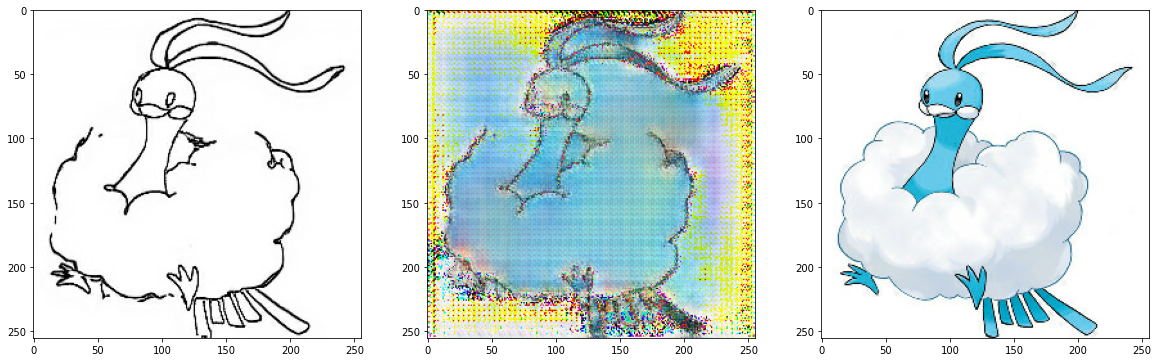

In [26]:
# 채색하기
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

- EPOCHS = 10으로 설정했기 때문에 아직 제대로 된 결과를 얻기는 힘들다. EPOCHS을 늘리면 더 잘 채색된 결과를 얻을 수 있다.